In [11]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.basemap import Basemap
import xarray as xr
import math
import time
import random
from skimage.morphology import binary_erosion
import matplotlib.colors as mcolors
import os, sys
from rrtstar_netcdf import RRTStar
from rrt_netcdf import RRT

show_animation = False

In [12]:
data = xr.open_dataset('med-hcmr-wav-an-fc-h_1637573239403.nc')  # wave height 22 november
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
lats = data.variables['latitude'][:]
lons = data.variables['longitude'][:]
time = data.variables['time'][:]
wave = data.variables['VHM0'][:]
mask = data_stat.variables['mask'][0,:,:]
print(data)
print("------------------------------------------------------")
print(mask)

<xarray.Dataset>
Dimensions:    (latitude: 380, time: 24, longitude: 1307)
Coordinates:
  * latitude   (latitude) float32 30.19 30.23 30.27 30.31 ... 45.9 45.94 45.98
  * time       (time) datetime64[ns] 2021-11-22 ... 2021-11-22T23:00:00
  * longitude  (longitude) float32 -18.12 -18.08 -18.04 ... 36.21 36.25 36.29
Data variables:
    VHM0       (time, latitude, longitude) float32 ...
Attributes: (12/15)
    bulletin_type:                   forecast
    institution:                     Hellenic Centre for Marine Research (HCM...
    source:                          MEDWAM3
    credit:                          Copernicus Marine Environment Monitoring...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    producer:                        CMEMS-MED Monitoring and Forecasting Centre
    ...                              ...
    area:                            MED
    bulletin_date:                   2021-11-21 12
    FROM_ORIGINAL_FILE__field_type:  hourly_instanta

<ipython-input-13-412627b82e1f>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c_scheme = mp.pcolor(x, y, wave[0], cmap='jet')


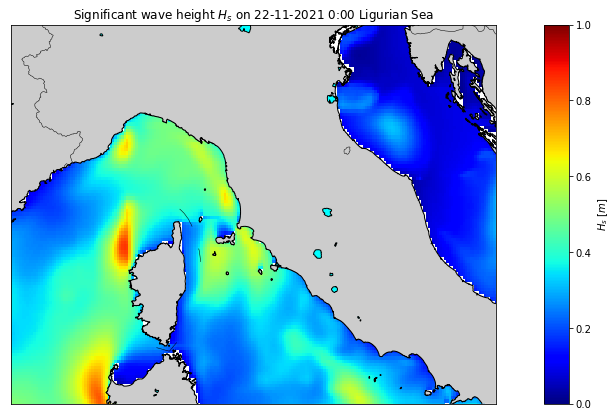

In [13]:
plt.figure(1, figsize=(10, 7))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='f')
             
lon, lat = np.meshgrid(lons, lats)
x, y = mp(lon, lat)

c_scheme = mp.pcolor(x, y, wave[0], cmap='jet')
mp.fillcontinents(lake_color='aqua')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
mp.drawmeridians(np.arange(6,15,1.0),labels=[0,0,0,1]) #longitudes
mp.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0]) #latitudes

cbar = mp.colorbar(c_scheme, location='right', pad='10%')
plt.clim(0, 1)
cbar.set_label('$H_s$ $[m]$')

plt.title('Significant wave height $H_s$ on 22-11-2021 0:00 Ligurian Sea')
plt.show()

#### Defining area not safe

<ipython-input-14-56f4ef9816bd>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c_scheme = mp.pcolor(x, y, cost, cmap=ListedColormap(['white', 'red']))


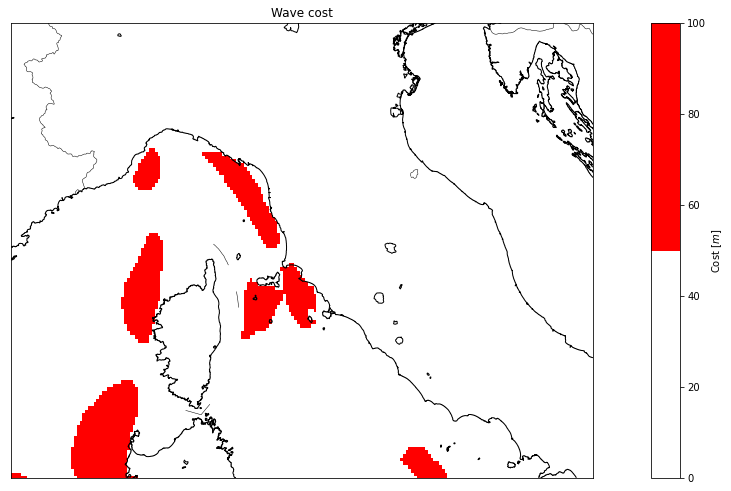

In [14]:
cost = 100 * (np.array(data.VHM0[0]) >0.5) # + 100 * (np.array(data.VHM0[0]) != (np.array(data.VHM0[0])))

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
c_scheme = mp.pcolor(x, y, cost, cmap=ListedColormap(['white', 'red']))
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.plot()

cbar = mp.colorbar(c_scheme, location='right', pad='10%')
cbar.set_label('Cost $[m]$')
plt.title('Wave cost')

plt.show()

In [15]:
contour_raw_meteo=np.logical_xor(cost,binary_erosion(cost)) 
contour_raw_land=np.logical_xor(mask,binary_erosion(mask)) 

## RRT Start

The area of movement is:
x_min = 282249.730022532, y_min = 114007.03369052801
x_max = 564870.0725610546, y_max = 402247.96147155575


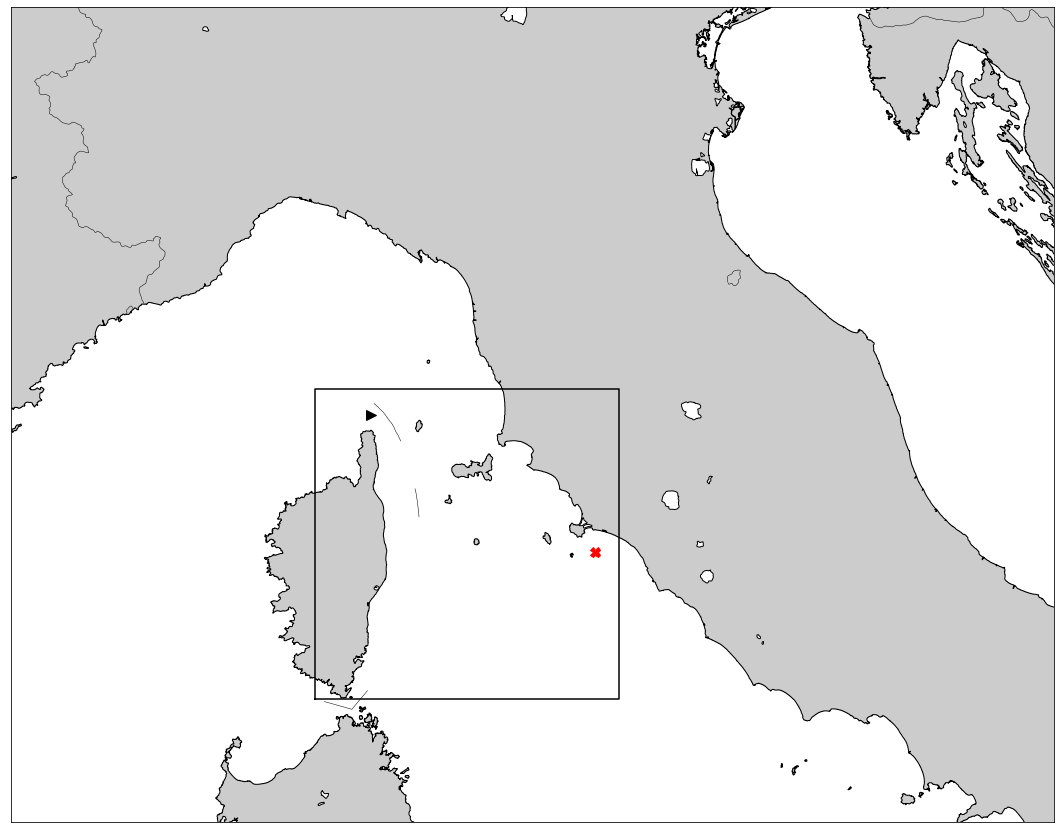

In [16]:
# rectangular area contour
x_min, y_min = mp(8.958334, 41.354168)    # lons.values[650], lats.values[268]
x_max, y_max = mp(11.500001, 43.270832)   # lons.values[711], lats.values[314]
print("The area of movement is:")
print("x_min = {}, y_min = {}\nx_max = {}, y_max = {}".format(x_min, y_min, x_max, y_max))

sx, sy = mp(9.42857, 43.11295)
gx, gy = mp(11.300001, 42.270832)

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.fillcontinents()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.savefig('conf_space.png', dpi=300)
plt.show()

### Obstacle definition

In [17]:
oxland, oyland = [], []     # all land points
oxmeteo, oymeteo = [], []   # all meteo points
Cspacex, Cspacey = [], []   # all configuration space points
x_obsm, y_obsm = [], []     # contour meteo points
x_obsl, y_obsl = [], []     # contour land points
for i in np.arange(0,380,1):
    for j in np.arange(0,1307,1):
        if lons.values[650] <= lons.values[j] <= lons.values[711] and lats.values[268] <= lats.values[i] <= lats.values[314]:
            if cost[i][j] == 100:
                oxmeteo.append(lons.values[j])
                oymeteo.append(lats.values[i])
            if contour_raw_meteo[i][j]:
                x_obsm.append(lons.values[j])
                y_obsm.append(lats.values[i])
            if contour_raw_land[i][j]: 
                x_obsl.append(lons.values[j])
                y_obsl.append(lats.values[i])
            if mask.values[i][j] == 0:
                oxland.append(lons.values[j])
                oyland.append(lats.values[i])
            else:
                Cspacex.append(lons.values[j])
                Cspacey.append(lats.values[i])
# mapping to basemap
oxland_, oyland_ = mp(oxland, oyland)       # land points
oxmeteo_, oymeteo_ = mp(oxmeteo, oymeteo)   # meteo points
Cspacex_, Cspacey_ = mp(Cspacex, Cspacey)
x_obsm_, y_obsm_ = mp(x_obsm, y_obsm)       # meteo contour points
x_obsl_, y_obsl_ = mp(x_obsl, y_obsl)       # coastline points

x_obstot_ = x_obsm_ + x_obsl_
y_obstot_ = y_obsm_ + y_obsl_

In [18]:
scenario = input('Press a number between 1 and 3 \n')
print("Scenario " + scenario + " has been pressed")

Press a number between 1 and 3 
 1


Scenario 1 has been pressed


There are 240 obstacles


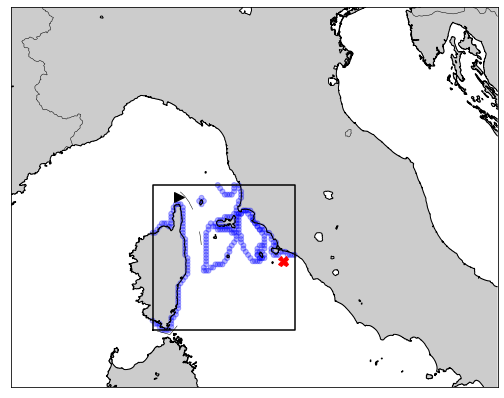

In [19]:
obstacle_list = []
for i, _ in enumerate(x_obsm_):
    obstacle_list.append([x_obsm_[i], y_obsm_[i], 5000])
for i, _ in enumerate(x_obsl_):
    obstacle_list.append([x_obsl_[i], y_obsl_[i], 5000])  
print("There are {} obstacles".format(len(obstacle_list)))

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
mp.fillcontinents()
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
for i in range(len(obstacle_list)):
    ax.add_patch(plt.Circle(xy=(obstacle_list[i][0], obstacle_list[i][1]), radius=obstacle_list[i][2],
                            color='b', alpha=0.3))
plt.show()

In [37]:
rrt = RRT(
        start=[sx, sy],
        goal=[gx, gy],
        rand_area=[x_min, x_max, y_min, y_max],
        c_spacex = Cspacex_,
        c_spacey = Cspacey_,
        obstacle_list=obstacle_list,
        expand_dis=5000,
        path_resolution=2500,  # changing path resolution reduces a lot the computation time
        goal_sample_rate=10) 

In [20]:
import time
start_time = time.time()
path_rrt = rrt.planning(animation=show_animation)
end_time = time.time()
if path_rrt is None:
    print("Cannot find path")
else:
    print("Found path!!")
print("The computational time is " + str(round(end_time - start_time, 4)) + " seconds")

NameError: name 'rrt' is not defined

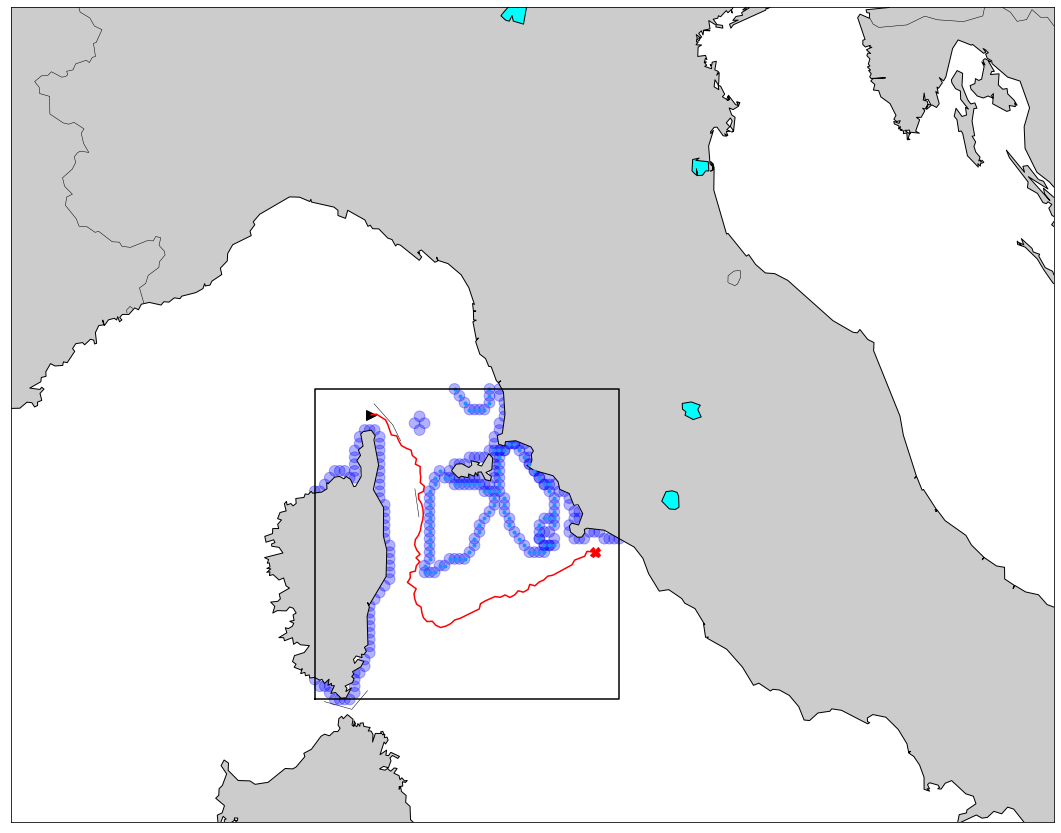

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
plt.plot(x_obsm_, y_obsm_, ".", color='dodgerblue')
for i in range(len(obstacle_list)):
    ax.add_patch(plt.Circle(xy=(obstacle_list[i][0], obstacle_list[i][1]), radius=obstacle_list[i][2],
                            color='b', alpha=0.3))
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.plot([x for (x, y) in path_rrt], [y for (x, y) in path_rrt], '-r')
mp.fillcontinents(lake_color='aqua')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

plt.show()

In [21]:
rrt_star = RRTStar(
            start=[sx, sy],
            goal=[gx, gy],
            rand_area=[x_min, x_max, y_min, y_max],
            obstacle_list=obstacle_list,
            c_spacex = Cspacex_,
            c_spacey = Cspacey_,
            path_resolution=2500.0,
            connect_circle_dist=20000.0,
            expand_dis=5000)


In [22]:
start_time = time.time()
path_star, cost_tot, iter_tot = rrt_star.planning(animation=show_animation)
end_time = time.time()
if path_star is None:
    print("Cannot find path")
else:
    print("Found path!!")

print("The computational time is " + str(round(end_time - start_time, 4)) + " seconds")

Found path!!
The computational time is 1.2127 seconds


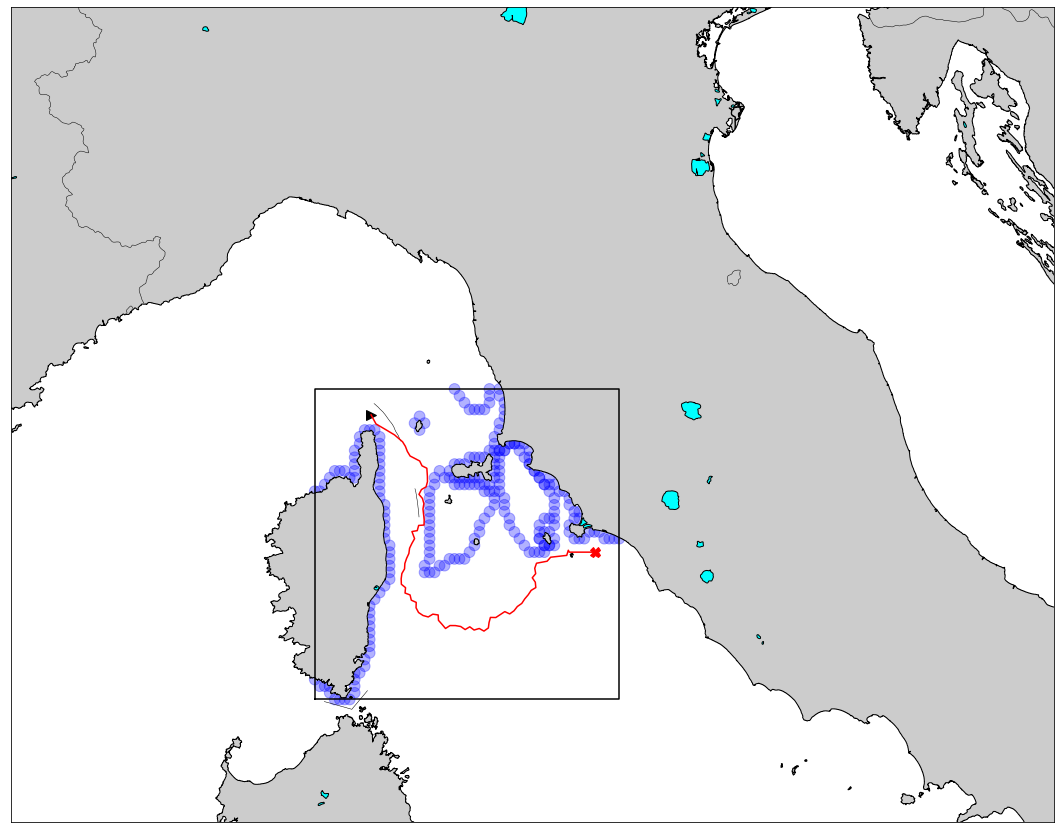

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
for i in range(len(obstacle_list)):
    ax.add_patch(plt.Circle(xy=(obstacle_list[i][0], obstacle_list[i][1]), radius=obstacle_list[i][2],
                            color='b', alpha=0.3))
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.plot([x for (x, y) in path_star], [y for (x, y) in path_star], '-r')
mp.fillcontinents(lake_color='aqua')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [75]:
print("The distance to the mission area is " + str(round(cost_tot/1000, 2)) + " km")

The distance to the mission area is 379.44 km
